In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import gc
gc.collect()

35

In [14]:
import rasterio
import numpy as np

def process_image(image_filename, patch_size=(256, 256), thr=0.5):
    """
    Load image, cut to pathes, delete empty by nonzero_threshold. Save indexes of saved images to get their masks
    
    Args:
    image_filename - filename of the image to be loaded
    patch_size - size of a patch to cut the source image
    thr - if the patch is empty for more than thr - it will be deleted
    
    """
    with rasterio.open(image_filename) as src:
        image = src.read()  # (C, H, W)

    image = np.transpose(image, (1, 2, 0))

    H, W, _ = image.shape
    ph, pw = patch_size
    image_patches = []
    valid_indices = []

    idx = 0
    for i in range(0, H, ph):
        for j in range(0, W, pw):
            img_patch = image[i:i+ph, j:j+pw]

            # Skip patches that are not full
            if img_patch.shape[0] != ph or img_patch.shape[1] != pw:
                continue
            
            # Counting nonzero pixels
            # ? print(img_patch.shape)
            nonzero = np.count_nonzero(img_patch)
            total = img_patch.size  

            if (nonzero / total) >= thr:
                image_patches.append(img_patch)
                valid_indices.append(idx) 
            idx += 1

    image_patches = np.array(image_patches, dtype=np.float32)
    
    np.save('image_patches.npy', image_patches)

    print(f"Images preprocessed, saved {len(image_patches)} pathes.")
    return valid_indices  


def process_mask(mask_filename, valid_indices, patch_size=(256, 256)):
    """
    Load mask, cut it to pathes, saves the patches that has indexes from valid_indeces
    """
    with rasterio.open(mask_filename) as src:
        mask = src.read(1)  # Get first channel

    H, W = mask.shape
    ph, pw = patch_size
    mask_patches = []

    idx = 0
    for i in range(0, H, ph):
        for j in range(0, W, pw):
            mask_patch = mask[i:i+ph, j:j+pw]

            if mask_patch.shape[0] != ph or mask_patch.shape[1] != pw:
                continue

            if idx in valid_indices:
                mask_patches.append(mask_patch)
            idx += 1

    mask_patches = np.array(mask_patches, dtype=np.uint8)
    np.save('mask_patches.npy', mask_patches)

    print(f"Masks preprocessed, saved {len(mask_patches)} pathes.")


image_filename = './source_images/merged_masked.tif'
mask_filename = './source_images/drainage_rasterized_masked.tif'

valid_indices = process_image(image_filename)

process_mask(mask_filename, valid_indices)

Images preprocessed, saved 2969 pathes.
Masks preprocessed, saved 2969 pathes.


At the current moment the order of layers is: DEM + RGB. We want it to be R + G + B + DEM, so we'll reorder channels

In [56]:
import numpy as np
import matplotlib.pyplot as plt


image_patches = np.load('image_patches.npy')  # (N, 256, 256, 4)
mask_patches = np.load('mask_patches.npy')  # (N, 256, 256)

assert image_patches.shape[0] == mask_patches.shape[0], "Number of images and masks is not equal"

image_patches = image_patches[:, :, :, [1, 2, 3, 0]]

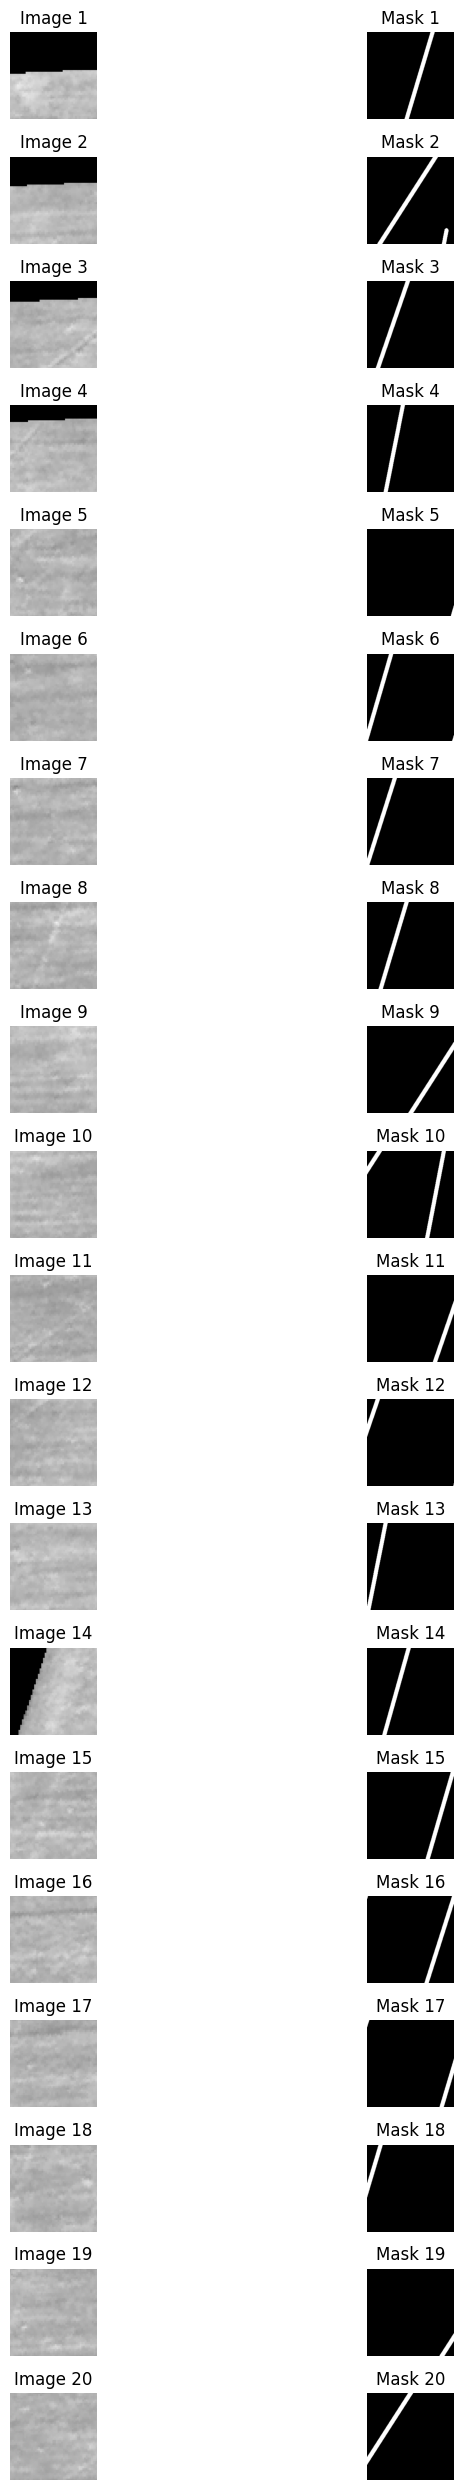

In [ ]:
# Watch first 5 examples where mask is not empty
selected_images = []
selected_masks = []
for img, mask in zip(image_patches, mask_patches):
    if np.count_nonzero(mask) > 0:  
        selected_images.append(img)
        selected_masks.append(mask)
    
    if len(selected_images) == 20:
        break  

fig, axes = plt.subplots(20, 2, figsize=(10, 25))

for i, (img, mask) in enumerate(zip(selected_images, selected_masks)):
    # RGB channels are now 0, 1, 2
    rgb_img = img[:, :, [0, 1, 2]]  

    # Normalization
    rgb_img = rgb_img / 255

    # Show image
    axes[i, 0].imshow(rgb_img)
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis("off")

    # Show mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f"Mask {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [58]:
from helper.utilities import *

save_train_test_split('test_bad', image_patches, mask_patches)

Successfully saved data in:
  - g:\Universe\Materials\Github Repos\Drainage-detection-topography\datasets\test_bad\train
  - g:\Universe\Materials\Github Repos\Drainage-detection-topography\datasets\test_bad\val
  - g:\Universe\Materials\Github Repos\Drainage-detection-topography\datasets\test_bad\test
